# Spherical Harmonic Normalizations and Parseval's theorem

In [1]:
%matplotlib inline
from __future__ import print_function # only necessary if using Python 2.x

import matplotlib.pyplot as plt
import numpy as np
from pyshtools.shclasses import SHCoeffs, SHGrid, SHWindow

## The energy and variance of a single spherical harmonic

We demonstrate in this paragraph two properties of the 4-pi normalized spherical harmonics. We initializing the coefficient class with a single non-zero coefficient. To make things simple, we fix the coefficient value, and therefore also its energy, to 1.

We then compute the normalization N that is by default fixed to 4pi in shtools. The variance of the spherical harmonic is the integral of its squared amplitude (norm) divided by the surface area of the sphere (4pi) and should in the 4pi normalization correspond to 1.

$$N = \int_\Omega Y^2_{lm}(\mathbf{r})~d\Omega$$
$$Var(Y_{lm}(\mathbf{r})) = \frac{N}{4 \pi} = 1$$

The integrals are easy to compute using the DH2 grid that has an equal spacing in latitude and longitude.

total coefficient power is  1.0


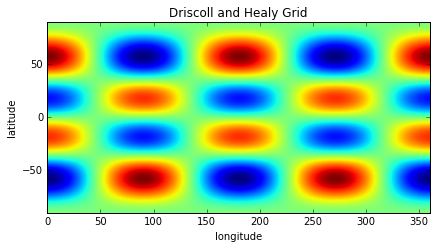

correct surface (4 pi) = 12.566370614359172
computed surface = 12.5661122277
computed spherical harmonics energy = 12.5663706143
variance = spherical harmonics energy / surface = 1.00002056217


In [2]:
# Initialize the model with a single harmonic set to 1.
lmax = 99
coeffs = SHCoeffs.from_zeros(lmax)
coeffs.set_coeffs(values=[1], ls=[5], ms=[2])
power = coeffs.powerspectrum()
print('total coefficient power is ', power.sum())

grid = coeffs.expand('DH2')
grid.plot()

# Generate an empty spatial grid
lats = grid.lats()
lons = grid.lons()
latgrid, longrid = np.meshgrid(lats, lons, indexing='ij')

# Next, compute the weights used to integrate the function.
# This will only be approximate.
weights = np.cos(np.radians(latgrid))
dlat = np.radians(lats[0] - lats[1])
dlon = np.radians(lons[1] - lons[0])
surface = weights.sum() * dlat * dlon
print('correct surface (4 pi) =', 4 * np.pi)
print('computed surface =', surface)

# Finally, compute the model variance
sh_energy = np.sum(grid.data**2 * weights) * dlat * dlon

print('computed spherical harmonics energy =', sh_energy)
print('variance = spherical harmonics energy / surface =', sh_energy / surface)

## Parseval's theorem in the case of a random model

We have seen in the previous example, that a single 4pi normalized spherical harmonic has unit variance. Because spherical harmonics are orthogonal functions on the sphere, *the total variance of a model is the sum of the variances of its' 4pi-normalized spherical harmonics coefficients*.

If the coefficients of all spherical harmonics are independent, the distribution will become Gaussian as predicted by the central limit theorem, or it will be perfectly Gaussian if the individual coefficients were Gaussian in the first place.

We illustrate this behaviour in the following short code snippet.

total coefficient power = 41.5643328191


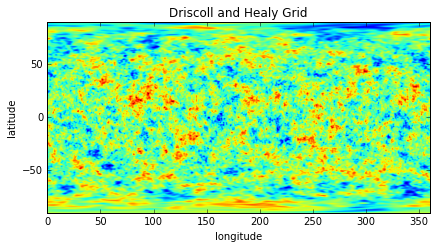

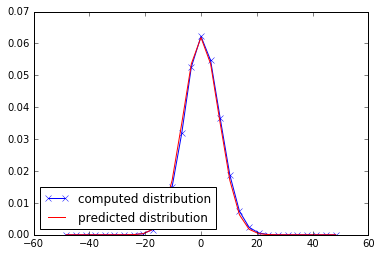

In [3]:
nl = 200
a = 30
ls = np.arange(nl, dtype=float)
power = 1. / (1. + (ls / a) ** 2) ** 1
coeffs = SHCoeffs.from_random(power)
power_random = coeffs.powerspectrum()
total_power = power_random.sum()
print('total coefficient power =', total_power)

grid = coeffs.expand('DH2')
grid.plot()

# Generate a spatial grid.
lats = grid.lats()
lons = grid.lons()
latgrid, longrid = np.meshgrid(lats, lons, indexing='ij')

# First, compute the spherical surface element to weight
# the different grid points when constructing a histogram.
weights = np.cos(np.radians(latgrid))
dlat = np.radians(lats[0] - lats[1])
dlon = np.radians(lons[1] - lons[0])
surface = weights.sum() * dlat * dlon

# Compute a histogram of the grided data.
bins = np.linspace(-50, 50, 30)
center = 0.5 * (bins[:-1] + bins[1:])
dbin = center[1] - center[0]
hist, bins = np.histogram(grid.data, bins=bins, weights=weights, density=True)

# Compute the expected distribution.
normal_distribution = np.exp( - center ** 2 / (2 * total_power))
normal_distribution /= dbin * normal_distribution.sum()

# Plot both distributions.
fig, ax = plt.subplots(1, 1)
ax.plot(center, hist, '-x', c='blue', label='computed distribution')
ax.plot(center, normal_distribution, c='red', label='predicted distribution')
ax.legend(loc=3);